# Phase 2: Feature Engineering & Machine Learning Models

## Study Resource Recommender

**Objective:** Train 5 ML models to predict student mastery level on skills, which will be used to recommend appropriate YouTube videos.

---

## Models to Train

| # | Model | Type |
|---|-------|------|
| 1 | Random Forest | Ensemble |
| 2 | XGBoost | Gradient Boosting |
| 3 | Logistic Regression | Linear |
| 4 | K-Nearest Neighbors (KNN) | Instance-based |
| 5 | Neural Network (MLP) | Deep Learning |

---

## Target Variable

```
mastery_level:
  - needs_help: Student struggling (accuracy < 60%)
  - learning: Student progressing (60% ≤ accuracy < 80%)
  - mastered: Student proficient (accuracy ≥ 80%, low hints)
```

## 1. Import Libraries

In [1]:
# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder

# ML Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

# XGBoost
# !pip install xgboost (uncomment if not installed)
from xgboost import XGBClassifier

# Evaluation
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    ConfusionMatrixDisplay
)

# Save models
import joblib
import pickle

# Warnings
import warnings
warnings.filterwarnings('ignore')

print("✅ All libraries imported successfully!")

✅ All libraries imported successfully!


## 2. Load Data from Phase 1

In [2]:
# Load the student skill performance dataset from Phase 1
df = pd.read_csv('/content/Final_student_skill_performance.csv')

print(f"Dataset Shape: {df.shape}")
print(f"Number of Students: {df['user_id'].nunique()}")
print(f"Number of Skills: {df['skill_name'].nunique()}")
df.head()

Dataset Shape: (2485, 12)
Number of Students: 1172
Number of Skills: 7


,user_id,skill_name,total_correct,total_attempts,accuracy,total_hints_used,avg_hint_ratio,avg_attempts,avg_response_time,pct_hint_first,difficulty_score,mastery_level
0,14,circle graph,3,12,0.250000,13.0,0.50,1.0,32.656750,0.0,0.450054,needs_help
1,21825,table,4,7,0.571429,0.0,0.00,1.0,98.368429,0.0,0.171483,needs_help
2,52613,number line,0,1,0.000000,4.0,1.00,1.0,21.668000,0.0,0.700054,needs_help
3,53167,scatter plot,3,5,0.600000,1.0,0.05,1.6,14.483000,0.0,0.175086,learning
4,53167,table,13,16,0.812500,0.0,0.00,1.0,35.575313,0.0,0.075054,mastered


In [3]:
# Check data types and missing values
print("Data Types:")
print(df.dtypes)
print("\nMissing Values:")
print(df.isnull().sum())

Data Types:
user_id                int64
skill_name            object
total_correct          int64
total_attempts         int64
accuracy             float64
total_hints_used     float64
avg_hint_ratio       float64
avg_attempts         float64
avg_response_time    float64
pct_hint_first       float64
difficulty_score     float64
mastery_level         object
dtype: object

Missing Values:
user_id              0
skill_name           0
total_correct        0
total_attempts       0
accuracy             0
total_hints_used     0
avg_hint_ratio       0
avg_attempts         0
avg_response_time    0
pct_hint_first       0
difficulty_score     0
mastery_level        0
dtype: int64


In [4]:
# Check target variable distribution
print("Target Variable Distribution:")
print(df['mastery_level'].value_counts())
print("\nPercentages:")
print(df['mastery_level'].value_counts(normalize=True).round(3) * 100)

Target Variable Distribution:
mastery_level
mastered      1178
needs_help     665
learning       642
Name: count, dtype: int64

Percentages:
mastery_level
mastered      47.4
needs_help    26.8
learning      25.8
Name: proportion, dtype: float64


## 3. Feature Engineering

In [5]:
# Create additional features to improve model performance

# 1. Efficiency score: correct answers relative to hints used
df['efficiency_score'] = df['total_correct'] / (df['total_hints_used'] + 1)

# 2. Struggle indicator: high attempts + high hints + low accuracy
df['struggle_score'] = (
    (1 - df['accuracy']) * 0.4 +
    df['avg_hint_ratio'] * 0.3 +
    (df['avg_attempts'] / df['avg_attempts'].max()) * 0.3
)

# 3. Speed score: normalized response time (lower is faster)
df['speed_score'] = 1 - (df['avg_response_time'] / df['avg_response_time'].max()).clip(0, 1)

# 4. Hint dependency: combination of hint metrics
df['hint_dependency'] = (df['avg_hint_ratio'] + df['pct_hint_first']) / 2

# 5. Attempts per correct answer
df['attempts_per_correct'] = df['total_attempts'] / (df['total_correct'] + 1)

print("✅ New features created!")
print(f"Total features now: {len(df.columns)}")

✅ New features created!
Total features now: 17


In [6]:
# Handle any infinite or NaN values from calculations
df = df.replace([np.inf, -np.inf], np.nan)
df = df.fillna(df.median(numeric_only=True))

print("✅ Missing/infinite values handled!")

✅ Missing/infinite values handled!


In [7]:
# View all features
print("All columns in dataset:")
for i, col in enumerate(df.columns):
    print(f"  {i+1}. {col}")

All columns in dataset:
  1. user_id
  2. skill_name
  3. total_correct
  4. total_attempts
  5. accuracy
  6. total_hints_used
  7. avg_hint_ratio
  8. avg_attempts
  9. avg_response_time
  10. pct_hint_first
  11. difficulty_score
  12. mastery_level
  13. efficiency_score
  14. struggle_score
  15. speed_score
  16. hint_dependency
  17. attempts_per_correct


## 4. Prepare Features (X) and Target (y)

In [8]:
# Define feature columns for ML
feature_columns = [
    'accuracy',
    'total_correct',
    'total_attempts',
    'total_hints_used',
    'avg_hint_ratio',
    'avg_attempts',
    'avg_response_time',
    'pct_hint_first',
    'difficulty_score',
    # New engineered features
    'efficiency_score',
    'struggle_score',
    'speed_score',
    'hint_dependency',
    'attempts_per_correct'
]

# Check which columns exist in the dataframe
available_features = [col for col in feature_columns if col in df.columns]
print(f"Using {len(available_features)} features:")
for f in available_features:
    print(f"  - {f}")

Using 14 features:
  - accuracy
  - total_correct
  - total_attempts
  - total_hints_used
  - avg_hint_ratio
  - avg_attempts
  - avg_response_time
  - pct_hint_first
  - difficulty_score
  - efficiency_score
  - struggle_score
  - speed_score
  - hint_dependency
  - attempts_per_correct


In [9]:
# Create feature matrix (X) and target vector (y)
X = df[available_features].copy()
y = df['mastery_level'].copy()

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")

Features shape: (2485, 14)
Target shape: (2485,)


In [10]:
# Encode target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

print("Label Encoding:")
for i, label in enumerate(label_encoder.classes_):
    print(f"  {label} → {i}")

# Save encoder for later use
joblib.dump(label_encoder, 'label_encoder.pkl')
print("\n✅ Label encoder saved!")

Label Encoding:
  learning → 0
  mastered → 1
  needs_help → 2

✅ Label encoder saved!


## 5. Train-Test Split

In [11]:
# Split data: 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded,
    test_size=0.2,
    random_state=42,
    stratify=y_encoded  # Maintain class distribution
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"\nClass distribution in training set:")
print(pd.Series(y_train).value_counts().sort_index())

Training set: 1988 samples
Test set: 497 samples

Class distribution in training set:
0    514
1    942
2    532
Name: count, dtype: int64


## 6. Feature Scaling

In [12]:
# Scale features (important for KNN, Neural Network, Logistic Regression)
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Save scaler for deployment
joblib.dump(scaler, 'scaler.pkl')

print("✅ Features scaled!")
print(f"Mean of scaled features (should be ~0): {X_train_scaled.mean(axis=0).round(2)}")
print(f"Std of scaled features (should be ~1): {X_train_scaled.std(axis=0).round(2)}")

✅ Features scaled!
Mean of scaled features (should be ~0): [ 0.  0.  0.  0. -0.  0. -0.  0.  0. -0.  0.  0. -0. -0.]
Std of scaled features (should be ~1): [1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1.]


## 7. Train 5 ML Models

---

### Model 1: Random Forest Classifier

In [13]:
print("="*60)
print("MODEL 1: RANDOM FOREST CLASSIFIER")
print("="*60)

# Initialize model
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)

# Train model (Random Forest doesn't need scaled data)
rf_model.fit(X_train, y_train)

# Predictions
rf_pred = rf_model.predict(X_test)
rf_pred_proba = rf_model.predict_proba(X_test)

# Evaluation
rf_accuracy = accuracy_score(y_test, rf_pred)
rf_precision = precision_score(y_test, rf_pred, average='weighted')
rf_recall = recall_score(y_test, rf_pred, average='weighted')
rf_f1 = f1_score(y_test, rf_pred, average='weighted')

print(f"\n📊 Results:")
print(f"   Accuracy:  {rf_accuracy:.4f}")
print(f"   Precision: {rf_precision:.4f}")
print(f"   Recall:    {rf_recall:.4f}")
print(f"   F1-Score:  {rf_f1:.4f}")

# Cross-validation
rf_cv_scores = cross_val_score(rf_model, X_train, y_train, cv=5)
print(f"\n   Cross-Val Accuracy: {rf_cv_scores.mean():.4f} (+/- {rf_cv_scores.std()*2:.4f})")

# Save model
joblib.dump(rf_model, 'model_random_forest.pkl')
print("\n✅ Model saved: model_random_forest.pkl")

MODEL 1: RANDOM FOREST CLASSIFIER

📊 Results:
   Accuracy:  1.0000
   Precision: 1.0000
   Recall:    1.0000
   F1-Score:  1.0000

   Cross-Val Accuracy: 1.0000 (+/- 0.0000)

✅ Model saved: model_random_forest.pkl


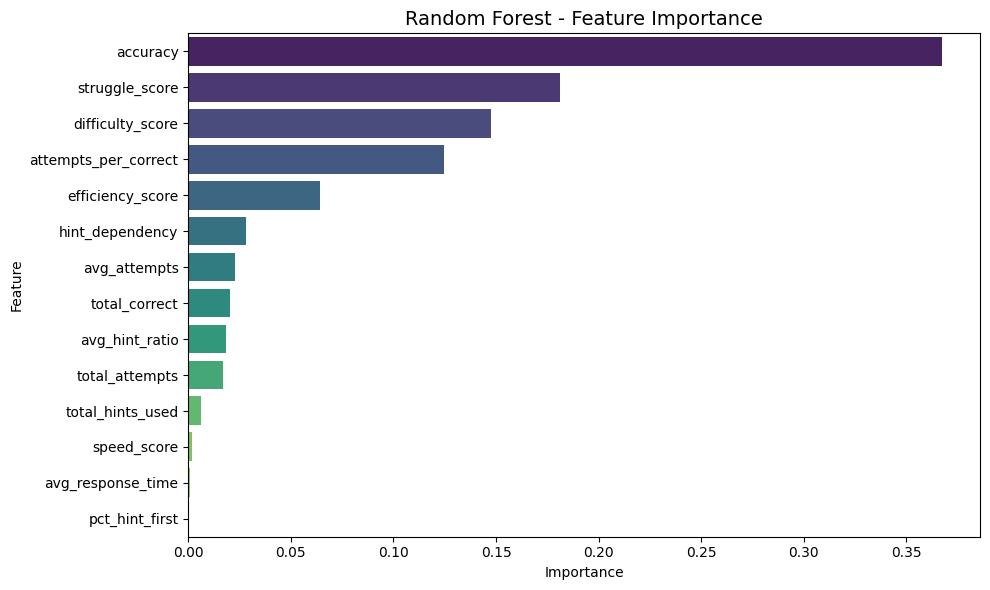

In [14]:
# Feature Importance for Random Forest
feature_importance = pd.DataFrame({
    'feature': available_features,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance, x='importance', y='feature', palette='viridis')
plt.title('Random Forest - Feature Importance', fontsize=14)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.savefig('rf_feature_importance.png', dpi=150)
plt.show()

### Model 2: XGBoost Classifier

In [15]:
print("="*60)
print("MODEL 2: XGBOOST CLASSIFIER")
print("="*60)

# Initialize model
xgb_model = XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    use_label_encoder=False,
    eval_metric='mlogloss'
)

# Train model
xgb_model.fit(X_train, y_train)

# Predictions
xgb_pred = xgb_model.predict(X_test)
xgb_pred_proba = xgb_model.predict_proba(X_test)

# Evaluation
xgb_accuracy = accuracy_score(y_test, xgb_pred)
xgb_precision = precision_score(y_test, xgb_pred, average='weighted')
xgb_recall = recall_score(y_test, xgb_pred, average='weighted')
xgb_f1 = f1_score(y_test, xgb_pred, average='weighted')

print(f"\n📊 Results:")
print(f"   Accuracy:  {xgb_accuracy:.4f}")
print(f"   Precision: {xgb_precision:.4f}")
print(f"   Recall:    {xgb_recall:.4f}")
print(f"   F1-Score:  {xgb_f1:.4f}")

# Cross-validation
xgb_cv_scores = cross_val_score(xgb_model, X_train, y_train, cv=5)
print(f"\n   Cross-Val Accuracy: {xgb_cv_scores.mean():.4f} (+/- {xgb_cv_scores.std()*2:.4f})")

# Save model
joblib.dump(xgb_model, 'model_xgboost.pkl')
print("\n✅ Model saved: model_xgboost.pkl")

MODEL 2: XGBOOST CLASSIFIER

📊 Results:
   Accuracy:  1.0000
   Precision: 1.0000
   Recall:    1.0000
   F1-Score:  1.0000

   Cross-Val Accuracy: 1.0000 (+/- 0.0000)

✅ Model saved: model_xgboost.pkl


### Model 3: Logistic Regression

In [16]:
print("="*60)
print("MODEL 3: LOGISTIC REGRESSION")
print("="*60)

# Initialize model
lr_model = LogisticRegression(
    multi_class='multinomial',
    solver='lbfgs',
    max_iter=1000,
    random_state=42
)

# Train model (using scaled data)
lr_model.fit(X_train_scaled, y_train)

# Predictions
lr_pred = lr_model.predict(X_test_scaled)
lr_pred_proba = lr_model.predict_proba(X_test_scaled)

# Evaluation
lr_accuracy = accuracy_score(y_test, lr_pred)
lr_precision = precision_score(y_test, lr_pred, average='weighted')
lr_recall = recall_score(y_test, lr_pred, average='weighted')
lr_f1 = f1_score(y_test, lr_pred, average='weighted')

print(f"\n📊 Results:")
print(f"   Accuracy:  {lr_accuracy:.4f}")
print(f"   Precision: {lr_precision:.4f}")
print(f"   Recall:    {lr_recall:.4f}")
print(f"   F1-Score:  {lr_f1:.4f}")

# Cross-validation
lr_cv_scores = cross_val_score(lr_model, X_train_scaled, y_train, cv=5)
print(f"\n   Cross-Val Accuracy: {lr_cv_scores.mean():.4f} (+/- {lr_cv_scores.std()*2:.4f})")

# Save model
joblib.dump(lr_model, 'model_logistic_regression.pkl')
print("\n✅ Model saved: model_logistic_regression.pkl")

MODEL 3: LOGISTIC REGRESSION

📊 Results:
   Accuracy:  0.9920
   Precision: 0.9922
   Recall:    0.9920
   F1-Score:  0.9920

   Cross-Val Accuracy: 0.9899 (+/- 0.0055)

✅ Model saved: model_logistic_regression.pkl


### Model 4: K-Nearest Neighbors (KNN)

In [17]:
print("="*60)
print("MODEL 4: K-NEAREST NEIGHBORS (KNN)")
print("="*60)

# Initialize model
knn_model = KNeighborsClassifier(
    n_neighbors=5,
    weights='distance',
    metric='euclidean',
    n_jobs=-1
)

# Train model (using scaled data)
knn_model.fit(X_train_scaled, y_train)

# Predictions
knn_pred = knn_model.predict(X_test_scaled)
knn_pred_proba = knn_model.predict_proba(X_test_scaled)

# Evaluation
knn_accuracy = accuracy_score(y_test, knn_pred)
knn_precision = precision_score(y_test, knn_pred, average='weighted')
knn_recall = recall_score(y_test, knn_pred, average='weighted')
knn_f1 = f1_score(y_test, knn_pred, average='weighted')

print(f"\n📊 Results:")
print(f"   Accuracy:  {knn_accuracy:.4f}")
print(f"   Precision: {knn_precision:.4f}")
print(f"   Recall:    {knn_recall:.4f}")
print(f"   F1-Score:  {knn_f1:.4f}")

# Cross-validation
knn_cv_scores = cross_val_score(knn_model, X_train_scaled, y_train, cv=5)
print(f"\n   Cross-Val Accuracy: {knn_cv_scores.mean():.4f} (+/- {knn_cv_scores.std()*2:.4f})")

# Save model
joblib.dump(knn_model, 'model_knn.pkl')
print("\n✅ Model saved: model_knn.pkl")

MODEL 4: K-NEAREST NEIGHBORS (KNN)

📊 Results:
   Accuracy:  0.9678
   Precision: 0.9677
   Recall:    0.9678
   F1-Score:  0.9677

   Cross-Val Accuracy: 0.9668 (+/- 0.0102)

✅ Model saved: model_knn.pkl


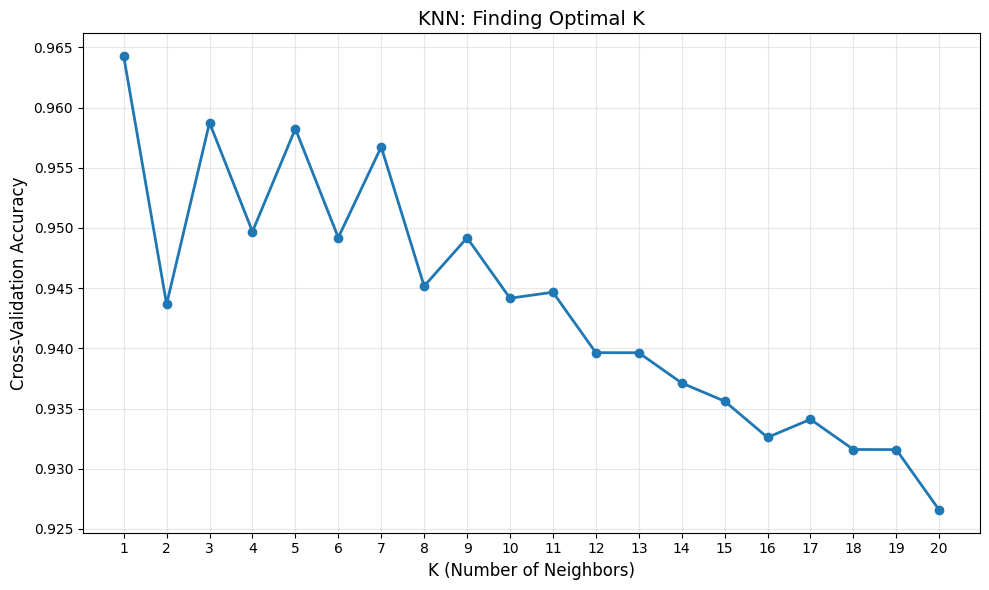

Optimal K: 1 with accuracy: 0.9643


In [18]:
# Find optimal K for KNN
k_range = range(1, 21)
k_scores = []

for k in k_range:
    knn_temp = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn_temp, X_train_scaled, y_train, cv=5)
    k_scores.append(scores.mean())

plt.figure(figsize=(10, 6))
plt.plot(k_range, k_scores, marker='o', linewidth=2, markersize=6)
plt.xlabel('K (Number of Neighbors)', fontsize=12)
plt.ylabel('Cross-Validation Accuracy', fontsize=12)
plt.title('KNN: Finding Optimal K', fontsize=14)
plt.xticks(k_range)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('knn_optimal_k.png', dpi=150)
plt.show()

print(f"Optimal K: {k_range[np.argmax(k_scores)]} with accuracy: {max(k_scores):.4f}")

### Model 5: Neural Network (MLP Classifier)

In [19]:
print("="*60)
print("MODEL 5: NEURAL NETWORK (MLP CLASSIFIER)")
print("="*60)

# Initialize model
mlp_model = MLPClassifier(
    hidden_layer_sizes=(128, 64, 32),  # 3 hidden layers
    activation='relu',
    solver='adam',
    learning_rate='adaptive',
    max_iter=500,
    early_stopping=True,
    validation_fraction=0.1,
    random_state=42
)

# Train model (using scaled data)
mlp_model.fit(X_train_scaled, y_train)

# Predictions
mlp_pred = mlp_model.predict(X_test_scaled)
mlp_pred_proba = mlp_model.predict_proba(X_test_scaled)

# Evaluation
mlp_accuracy = accuracy_score(y_test, mlp_pred)
mlp_precision = precision_score(y_test, mlp_pred, average='weighted')
mlp_recall = recall_score(y_test, mlp_pred, average='weighted')
mlp_f1 = f1_score(y_test, mlp_pred, average='weighted')

print(f"\n📊 Results:")
print(f"   Accuracy:  {mlp_accuracy:.4f}")
print(f"   Precision: {mlp_precision:.4f}")
print(f"   Recall:    {mlp_recall:.4f}")
print(f"   F1-Score:  {mlp_f1:.4f}")

# Cross-validation
mlp_cv_scores = cross_val_score(mlp_model, X_train_scaled, y_train, cv=5)
print(f"\n   Cross-Val Accuracy: {mlp_cv_scores.mean():.4f} (+/- {mlp_cv_scores.std()*2:.4f})")

# Save model
joblib.dump(mlp_model, 'model_neural_network.pkl')
print("\n✅ Model saved: model_neural_network.pkl")

MODEL 5: NEURAL NETWORK (MLP CLASSIFIER)

📊 Results:
   Accuracy:  1.0000
   Precision: 1.0000
   Recall:    1.0000
   F1-Score:  1.0000

   Cross-Val Accuracy: 0.9884 (+/- 0.0117)

✅ Model saved: model_neural_network.pkl


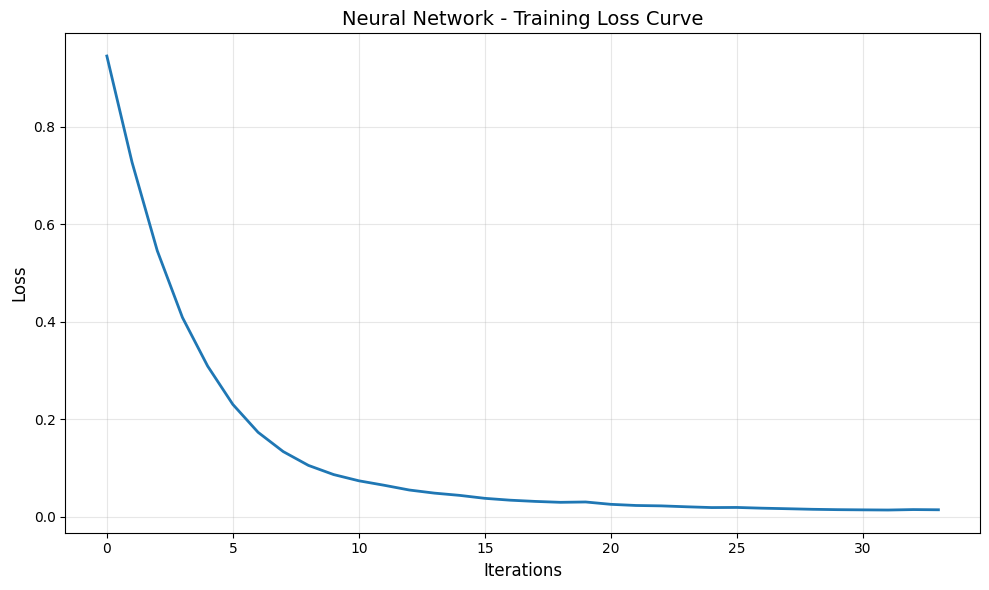

In [20]:
# Plot MLP training loss curve
plt.figure(figsize=(10, 6))
plt.plot(mlp_model.loss_curve_, linewidth=2)
plt.xlabel('Iterations', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Neural Network - Training Loss Curve', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('mlp_loss_curve.png', dpi=150)
plt.show()

## 8. Model Comparison

In [21]:
# Create comparison dataframe
model_comparison = pd.DataFrame({
    'Model': ['Random Forest', 'XGBoost', 'Logistic Regression', 'KNN', 'Neural Network'],
    'Accuracy': [rf_accuracy, xgb_accuracy, lr_accuracy, knn_accuracy, mlp_accuracy],
    'Precision': [rf_precision, xgb_precision, lr_precision, knn_precision, mlp_precision],
    'Recall': [rf_recall, xgb_recall, lr_recall, knn_recall, mlp_recall],
    'F1-Score': [rf_f1, xgb_f1, lr_f1, knn_f1, mlp_f1],
    'CV_Accuracy': [rf_cv_scores.mean(), xgb_cv_scores.mean(), lr_cv_scores.mean(),
                   knn_cv_scores.mean(), mlp_cv_scores.mean()]
})

# Sort by F1-Score
model_comparison = model_comparison.sort_values('F1-Score', ascending=False)

print("="*70)
print("MODEL COMPARISON SUMMARY")
print("="*70)
print(model_comparison.to_string(index=False))
print("="*70)

# Save comparison
model_comparison.to_csv('model_comparison.csv', index=False)

MODEL COMPARISON SUMMARY
              Model  Accuracy  Precision   Recall  F1-Score  CV_Accuracy
      Random Forest  1.000000   1.000000 1.000000  1.000000     1.000000
            XGBoost  1.000000   1.000000 1.000000  1.000000     1.000000
     Neural Network  1.000000   1.000000 1.000000  1.000000     0.988430
Logistic Regression  0.991952   0.992196 0.991952  0.991952     0.989941
                KNN  0.967807   0.967699 0.967807  0.967716     0.966804


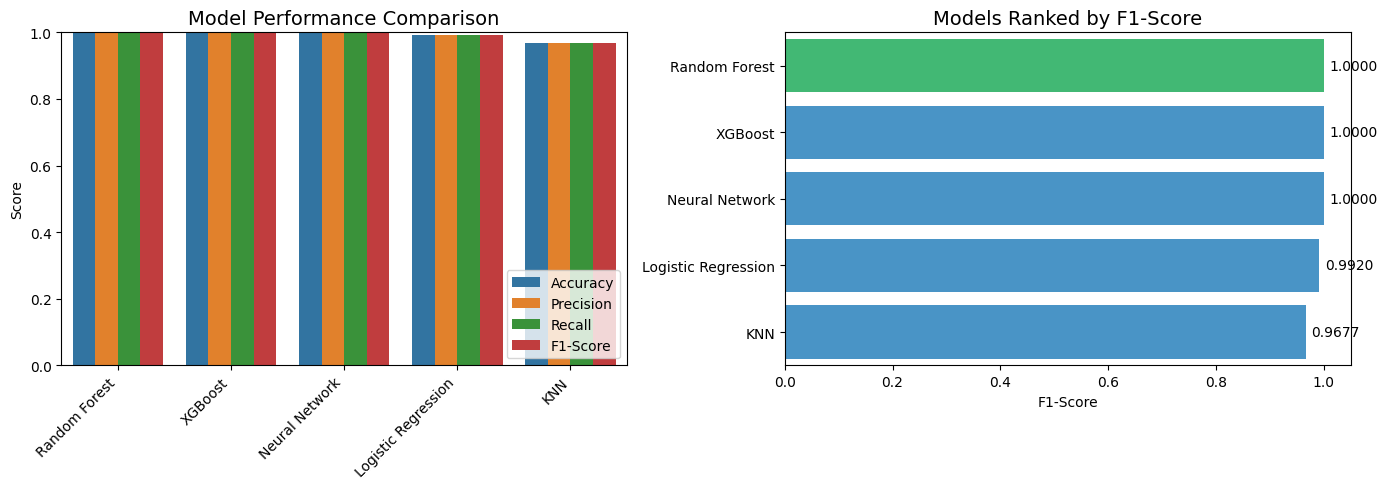

In [22]:
# Visualize model comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: All metrics comparison
metrics_df = model_comparison.melt(
    id_vars='Model',
    value_vars=['Accuracy', 'Precision', 'Recall', 'F1-Score'],
    var_name='Metric',
    value_name='Score'
)

sns.barplot(data=metrics_df, x='Model', y='Score', hue='Metric', ax=axes[0])
axes[0].set_title('Model Performance Comparison', fontsize=14)
axes[0].set_xlabel('')
axes[0].set_ylabel('Score')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')
axes[0].legend(loc='lower right')
axes[0].set_ylim(0, 1)

# Plot 2: F1-Score ranking
colors = ['#2ecc71' if i == 0 else '#3498db' for i in range(len(model_comparison))]
sns.barplot(data=model_comparison, x='F1-Score', y='Model', palette=colors, ax=axes[1])
axes[1].set_title('Models Ranked by F1-Score', fontsize=14)
axes[1].set_xlabel('F1-Score')
axes[1].set_ylabel('')

# Add value labels
for i, v in enumerate(model_comparison['F1-Score']):
    axes[1].text(v + 0.01, i, f'{v:.4f}', va='center')

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

## 9. Confusion Matrices

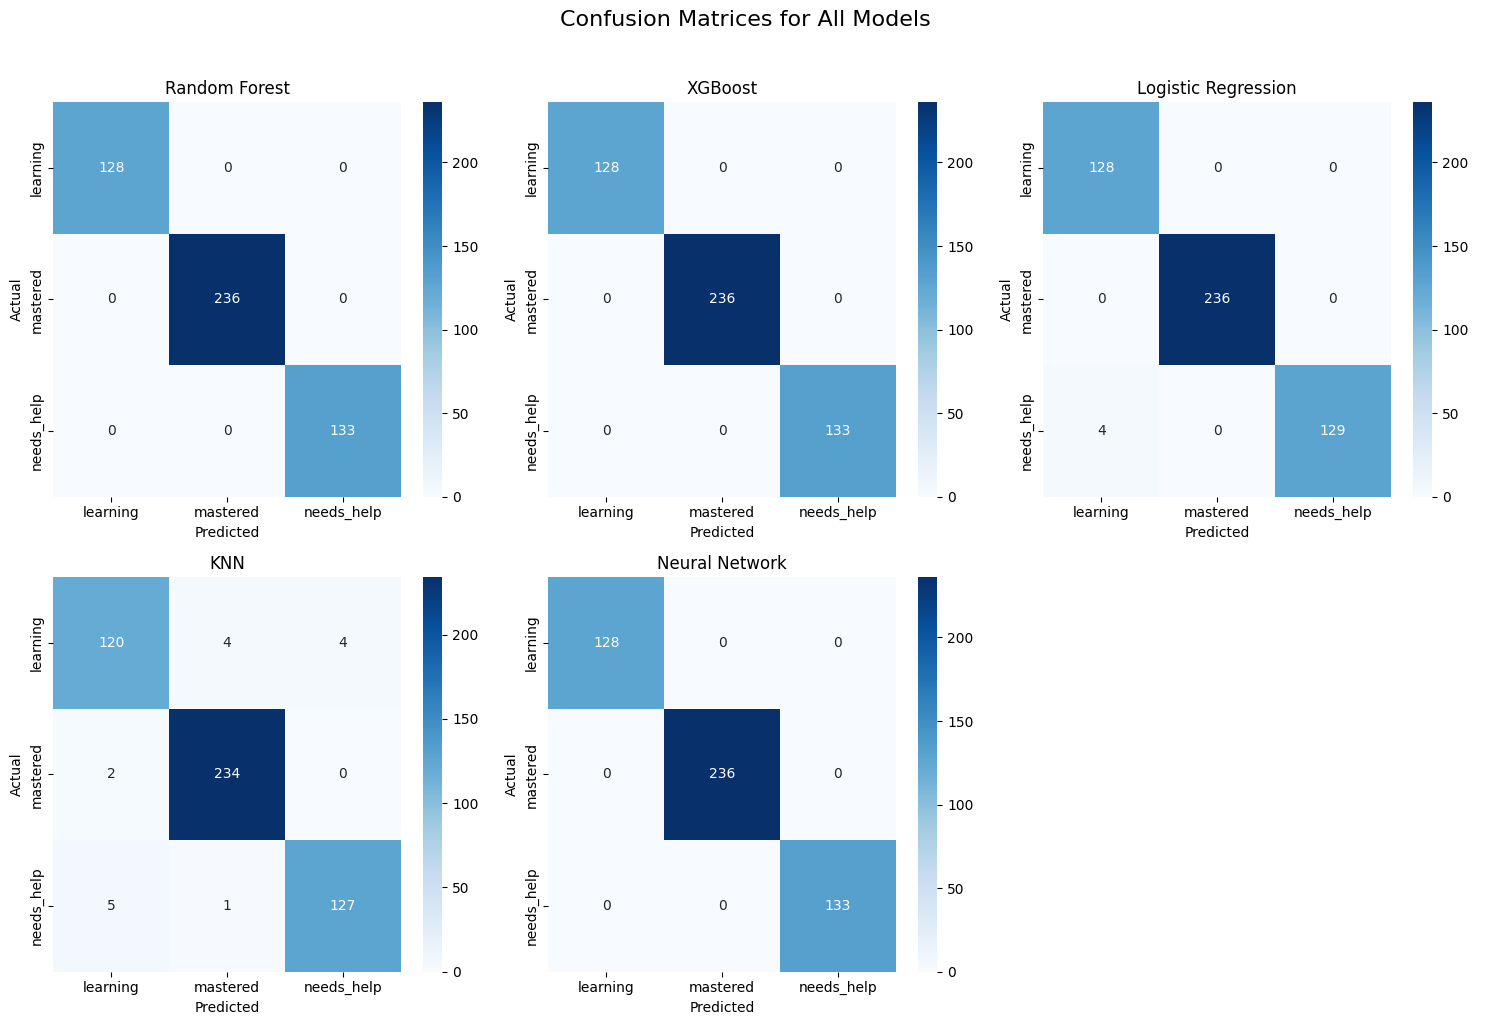

In [23]:
# Plot confusion matrices for all models
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

models_data = [
    ('Random Forest', rf_pred),
    ('XGBoost', xgb_pred),
    ('Logistic Regression', lr_pred),
    ('KNN', knn_pred),
    ('Neural Network', mlp_pred)
]

for idx, (name, pred) in enumerate(models_data):
    row = idx // 3
    col = idx % 3

    cm = confusion_matrix(y_test, pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[row, col],
                xticklabels=label_encoder.classes_,
                yticklabels=label_encoder.classes_)
    axes[row, col].set_title(f'{name}', fontsize=12)
    axes[row, col].set_xlabel('Predicted')
    axes[row, col].set_ylabel('Actual')

# Hide empty subplot
axes[1, 2].axis('off')

plt.suptitle('Confusion Matrices for All Models', fontsize=16, y=1.02)
plt.tight_layout()
plt.savefig('confusion_matrices.png', dpi=150, bbox_inches='tight')
plt.show()

## 10. Classification Reports

In [24]:
# Print detailed classification reports
print("\n" + "="*70)
print("DETAILED CLASSIFICATION REPORTS")
print("="*70)

for name, pred in models_data:
    print(f"\n{'='*50}")
    print(f"{name}")
    print('='*50)
    print(classification_report(y_test, pred, target_names=label_encoder.classes_))


DETAILED CLASSIFICATION REPORTS

Random Forest
              precision    recall  f1-score   support

    learning       1.00      1.00      1.00       128
    mastered       1.00      1.00      1.00       236
  needs_help       1.00      1.00      1.00       133

    accuracy                           1.00       497
   macro avg       1.00      1.00      1.00       497
weighted avg       1.00      1.00      1.00       497


XGBoost
              precision    recall  f1-score   support

    learning       1.00      1.00      1.00       128
    mastered       1.00      1.00      1.00       236
  needs_help       1.00      1.00      1.00       133

    accuracy                           1.00       497
   macro avg       1.00      1.00      1.00       497
weighted avg       1.00      1.00      1.00       497


Logistic Regression
              precision    recall  f1-score   support

    learning       0.97      1.00      0.98       128
    mastered       1.00      1.00      1.00       2

## 11. Select Best Model

In [25]:
# Identify best model
best_model_name = model_comparison.iloc[0]['Model']
best_model_f1 = model_comparison.iloc[0]['F1-Score']

print("="*60)
print("🏆 BEST MODEL SELECTED")
print("="*60)
print(f"\n   Model: {best_model_name}")
print(f"   F1-Score: {best_model_f1:.4f}")
print(f"\n   This model will be used for the recommendation system.")
print("="*60)

# Map to model object
model_objects = {
    'Random Forest': rf_model,
    'XGBoost': xgb_model,
    'Logistic Regression': lr_model,
    'KNN': knn_model,
    'Neural Network': mlp_model
}

best_model = model_objects[best_model_name]

# Save best model separately
joblib.dump(best_model, 'best_model.pkl')
print("\n✅ Best model saved as: best_model.pkl")

🏆 BEST MODEL SELECTED

   Model: Random Forest
   F1-Score: 1.0000

   This model will be used for the recommendation system.

✅ Best model saved as: best_model.pkl


## 12. Save Feature List for Deployment

In [26]:
# Save feature configuration
feature_config = {
    'feature_columns': available_features,
    'target_column': 'mastery_level',
    'label_classes': list(label_encoder.classes_),
    'best_model': best_model_name,
    'needs_scaling': best_model_name in ['Logistic Regression', 'KNN', 'Neural Network']
}

# Save as pickle
with open('feature_config.pkl', 'wb') as f:
    pickle.dump(feature_config, f)

print("✅ Feature configuration saved!")
print(f"\nFeatures used: {len(available_features)}")
for f in available_features:
    print(f"   - {f}")

✅ Feature configuration saved!

Features used: 14
   - accuracy
   - total_correct
   - total_attempts
   - total_hints_used
   - avg_hint_ratio
   - avg_attempts
   - avg_response_time
   - pct_hint_first
   - difficulty_score
   - efficiency_score
   - struggle_score
   - speed_score
   - hint_dependency
   - attempts_per_correct


## 13. Test Prediction Function

In [27]:
def predict_mastery(student_features, model, scaler, label_encoder, needs_scaling=True):
    """
    Predict mastery level for a student's skill performance.

    Parameters:
    - student_features: dict or DataFrame with feature values
    - model: trained ML model
    - scaler: fitted StandardScaler
    - label_encoder: fitted LabelEncoder
    - needs_scaling: whether the model requires scaled input

    Returns:
    - predicted_level: string (needs_help/learning/mastered)
    - probabilities: dict with probability for each class
    """
    # Convert to DataFrame if dict
    if isinstance(student_features, dict):
        student_features = pd.DataFrame([student_features])

    # Scale if needed
    if needs_scaling:
        features_processed = scaler.transform(student_features)
    else:
        features_processed = student_features

    # Predict
    prediction = model.predict(features_processed)[0]
    probabilities = model.predict_proba(features_processed)[0]

    # Decode prediction
    predicted_level = label_encoder.inverse_transform([prediction])[0]

    # Create probability dict
    prob_dict = {label: prob for label, prob in zip(label_encoder.classes_, probabilities)}

    return predicted_level, prob_dict


# Test with a sample student
sample_student = {
    'accuracy': 0.45,
    'total_correct': 5,
    'total_attempts': 11,
    'total_hints_used': 8,
    'avg_hint_ratio': 0.6,
    'avg_attempts': 2.2,
    'avg_response_time': 45.5,
    'pct_hint_first': 0.4,
    'difficulty_score': 0.65,
    'efficiency_score': 0.55,
    'struggle_score': 0.58,
    'speed_score': 0.7,
    'hint_dependency': 0.5,
    'attempts_per_correct': 2.2
}

# Only use features that exist
sample_student_filtered = {k: v for k, v in sample_student.items() if k in available_features}
sample_df = pd.DataFrame([sample_student_filtered])[available_features]

needs_scaling = best_model_name in ['Logistic Regression', 'KNN', 'Neural Network']
predicted_level, probabilities = predict_mastery(
    sample_df, best_model, scaler, label_encoder, needs_scaling
)

print("\n" + "="*50)
print("SAMPLE PREDICTION TEST")
print("="*50)
print(f"\nStudent Performance:")
print(f"   Accuracy: {sample_student.get('accuracy', 'N/A')}")
print(f"   Hint Ratio: {sample_student.get('avg_hint_ratio', 'N/A')}")
print(f"\nPrediction: {predicted_level.upper()}")
print(f"\nProbabilities:")
for level, prob in probabilities.items():
    print(f"   {level}: {prob:.2%}")


SAMPLE PREDICTION TEST

Student Performance:
   Accuracy: 0.45
   Hint Ratio: 0.6

Prediction: NEEDS_HELP

Probabilities:
   learning: 0.00%
   mastered: 0.00%
   needs_help: 100.00%


## 14. Summary

In [28]:
print("\n" + "="*70)
print("PHASE 2 COMPLETE - SUMMARY")
print("="*70)

print("\n📊 MODELS TRAINED:")
print("   1. Random Forest Classifier")
print("   2. XGBoost Classifier")
print("   3. Logistic Regression")
print("   4. K-Nearest Neighbors (KNN)")
print("   5. Neural Network (MLP)")

print(f"\n🏆 BEST MODEL: {best_model_name}")
print(f"   F1-Score: {best_model_f1:.4f}")

print("\n📁 FILES SAVED:")
print("   - model_random_forest.pkl")
print("   - model_xgboost.pkl")
print("   - model_logistic_regression.pkl")
print("   - model_knn.pkl")
print("   - model_neural_network.pkl")
print("   - best_model.pkl")
print("   - scaler.pkl")
print("   - label_encoder.pkl")
print("   - feature_config.pkl")
print("   - model_comparison.csv")

print("\n📈 VISUALIZATIONS SAVED:")
print("   - rf_feature_importance.png")
print("   - knn_optimal_k.png")
print("   - mlp_loss_curve.png")
print("   - model_comparison.png")
print("   - confusion_matrices.png")

print("\n" + "="*70)
print("NEXT: Phase 3 - Build Recommendation Engine")
print("="*70)


PHASE 2 COMPLETE - SUMMARY

📊 MODELS TRAINED:
   1. Random Forest Classifier
   2. XGBoost Classifier
   3. Logistic Regression
   4. K-Nearest Neighbors (KNN)
   5. Neural Network (MLP)

🏆 BEST MODEL: Random Forest
   F1-Score: 1.0000

📁 FILES SAVED:
   - model_random_forest.pkl
   - model_xgboost.pkl
   - model_logistic_regression.pkl
   - model_knn.pkl
   - model_neural_network.pkl
   - best_model.pkl
   - scaler.pkl
   - label_encoder.pkl
   - feature_config.pkl
   - model_comparison.csv

📈 VISUALIZATIONS SAVED:
   - rf_feature_importance.png
   - knn_optimal_k.png
   - mlp_loss_curve.png
   - model_comparison.png
   - confusion_matrices.png

NEXT: Phase 3 - Build Recommendation Engine


---

## Next Steps (Phase 3)

1. Load the best model and skill-video mapping
2. Build recommendation function:
   - Take student quiz results
   - Predict mastery level per skill
   - Identify weak skills (needs_help)
   - Match with relevant YouTube videos
   - Return ranked recommendations
3. Test with sample students